Before the resources were even published, we started working on the InSight Lander mission data. At first, downloading single data files one by one was inefficient, so we devised a download script to collect all data across the stations and years.

At first, we thought of engineering new features to work with, such as mean, standard deviation (std), Fast Forier Transform (FFT) mean, FFT std, and energy, then, transform the files into a pandas dataframe with these values. The issue with the mentioned approach is that it classifies a trace as an anomaly, or a seismic event, rather than identify an interval within the trace. This approach could work in case the trace's interval was small, around an hour for example. However, most traces were a full day record, which means every trace needs carefull exploration.

 \
Afterwards, we realized another mistake. That is, the location code corresponded to different measurements. The records contained velocity, position, temerature, pressure, and even wind, with the difference being which data was a raw transmission from the lander and which is a processed data on Earth. \
Learning from that mistake, we carefully examined the documents provided with the mission and started reprocessing our ideas.

The location code is made up of 3 letters: Band code, Instrument code, and Orientation code. Orientation codes are mostly our educated guesses, rather than direct translation from the documents like the Band codes and Instrument Codes.

In [1]:
band_code = { 'SP' : { # Short Period
    'E': 100,
    'S': [10, 80], # List elements are range, not discrete values
    'M': [2, 5],
    'L': 1,
    'V': [0.1 , 0.5],
    'U': [0.01, 0.05],
    'R': [1/3600, 0.001]
}, 
'VBB': { # Very Broadband
    'H': 100,
    'B': [10, 80],
    'M': [2, 5],
    'L': 1,
    'V': [0.1 , 0.5],
    'U': [0.01, 0.05],
    'R': [1/3600, 0.001]
}
}
instrument_code = {'H': 'High Gain Seismometer',
                   'L': 'Low Gain Seismometer',
                   'M': 'Mass Position Seismometer',
                   'D': 'Pressure',
                   'F': 'Magnetometer',
                   'k': 'Temperature',
                   'W': 'Wind',
                   'Z': 'Sythetized Beam Data',
                   'Y': 'Non-specific Instruments',
                   'E': 'Electric Test Point'
                   }
orientation_code = {'U': 'Up',
                    'V': 'Vertical (non-orthogonal VBB axis)',
                    'W': 'West (non-orthogonal VBB axis)',
                    # U, V, W are chosen because VBB axes are non-orthogonal.
                    'I': 'Instrument reference frame',
                    'S': 'Surface horizontal',
                    'D': 'Down',
                    'O': 'Operational mode or orientation unknown'
}


Before going into model development, we researched the lander's gadget. For instance, we learned that the Mars InSight Lander's main computer was based on the RAD750 radiation-hardened processor, which is a single-board computer. The RAD750 processor has a clock speed of approximately 200 MHz, 128 MB of DRAM, and 4 MB of EEPROM for storage. The system was designed to be highly reliable and resistant to the harsh conditions of space. Also, the Mars InSight Lander's main computer ran on a real-time operating system known as VxWorks. VxWorks is commonly used in space missions due to its reliability, real-time capabilities, and support for mission-critical applications. \
Therefore, the developed model should not use a lot of memory nor take some time to detect the seismic activties. Optimization is a crucial part of the mission.

After the resources were released, we explored the STA/LTA algorithm. It worked smoothly on some traces. However, since it neeeded predefined variables, threshold to classify the start of an event, it failed to work on other traces that had weaker signals. 

### STA/LTA on XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed file

In [2]:
!pip install obspy
import numpy as np
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.30
    Uninstalling SQLAlchemy-2.0.30:
      Successfully uninstalled SQLAlchemy-2.0.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
ipython-sql 0.5.0 requires sqlalc

Event detected at 704.6597869414853
Event ended at 854.2118640536673


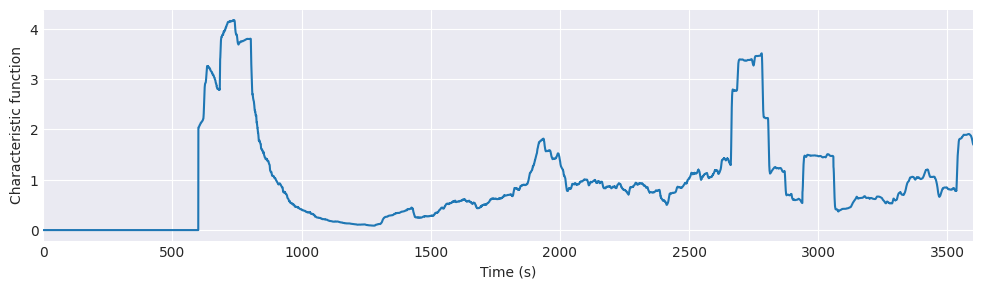

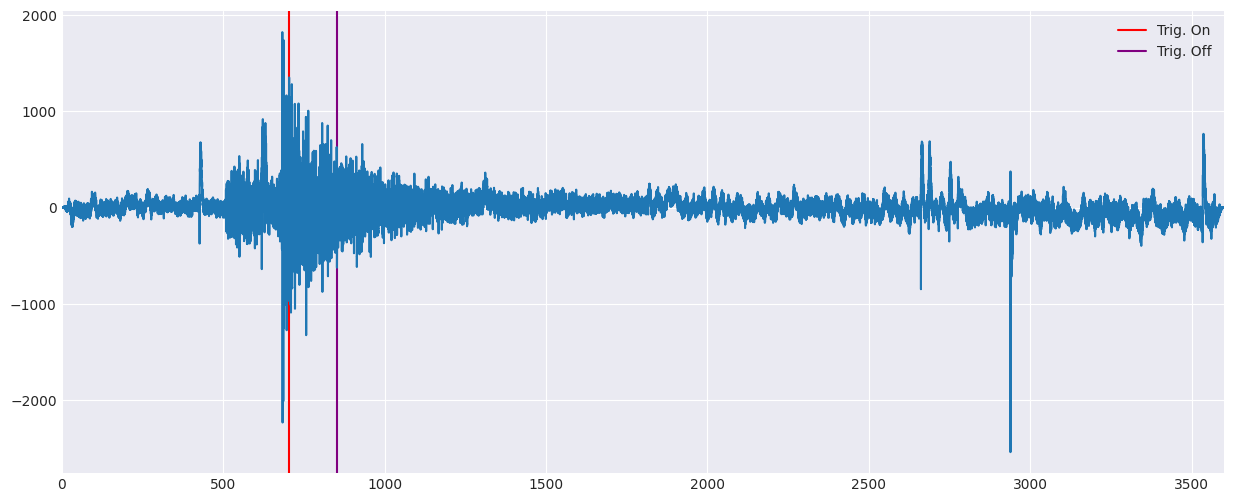

In [3]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed'
st = read(file_path)
tr = st[0]
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
    print(f'Event ended at {tr_times[triggers[1]]}')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

### Failed detection of XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed 

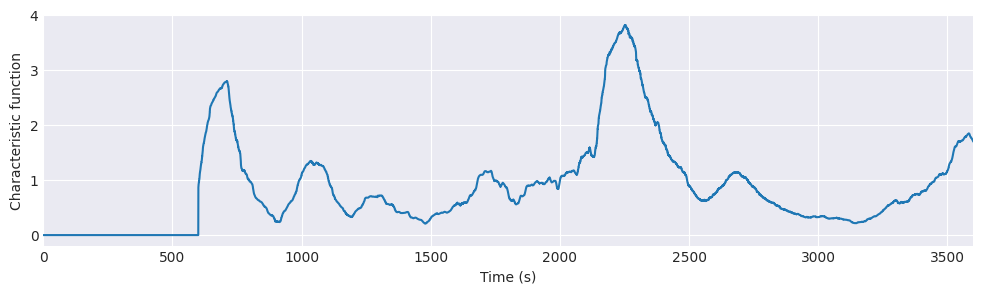

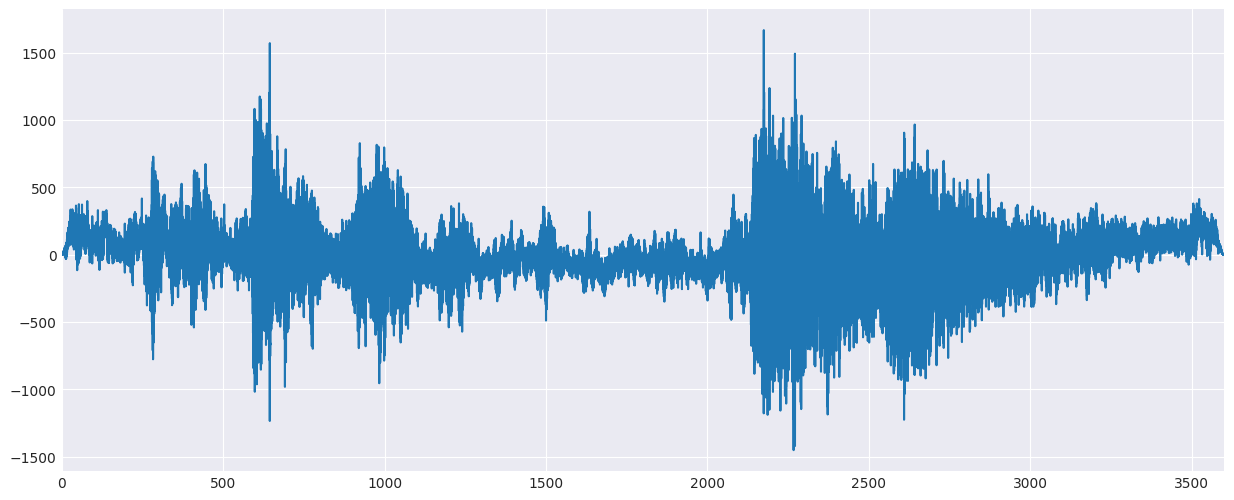

In [4]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed'
st = read(file_path)
tr = st[0]
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
df = tr.stats.sampling_rate
sta_len = 120
lta_len = 600
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
fig,ax = plt.subplots(1,1,figsize=(15,6))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    print(f'Event detected at {tr_times[triggers[0]]}')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
    print(f'Event ended at {tr_times[triggers[1]]}')
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

That's why we introduced the Isolation Forest. The machine learning model is capable of detecting outliers in the data points, and after detecting the outliers, we cluster points within 10 minutes as a single event.

### Isolation Forest on XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed and XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed files

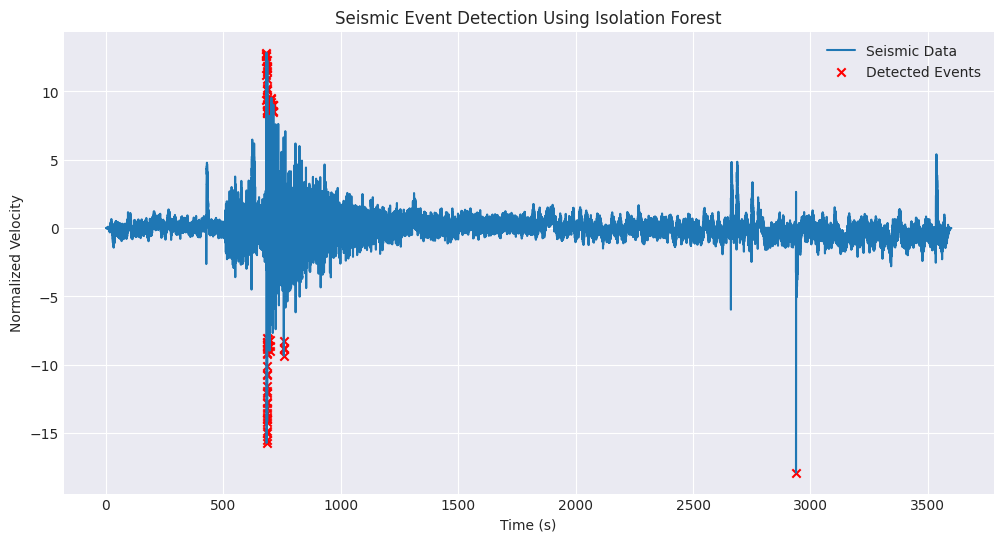

Clustered seismic events: [683.3594911040431]


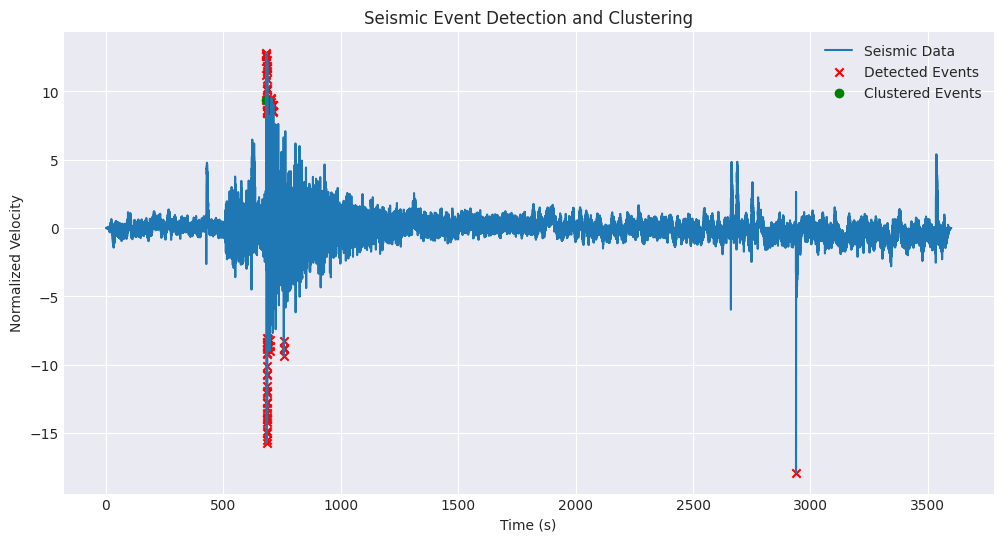

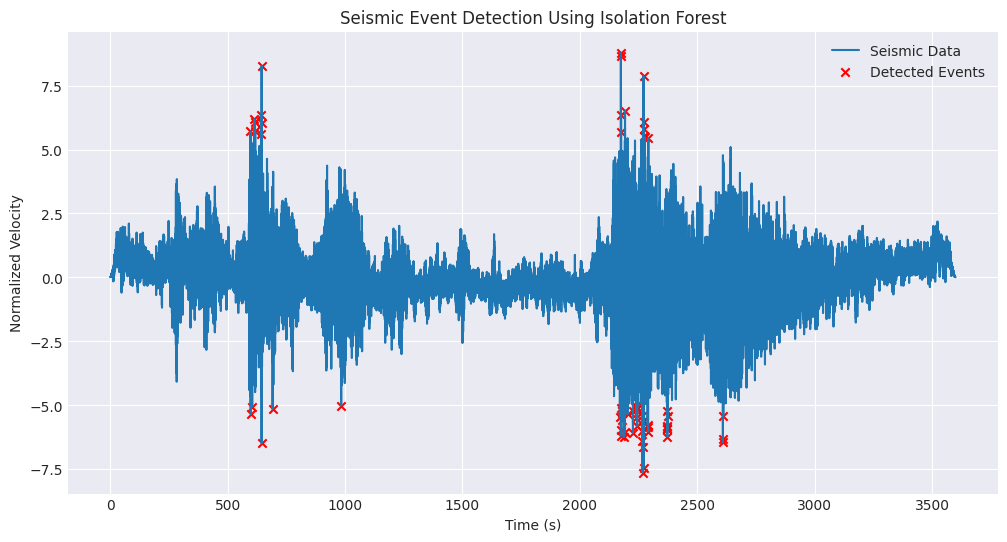

Clustered seismic events: [597.408297337463, 2170.3301434742148]


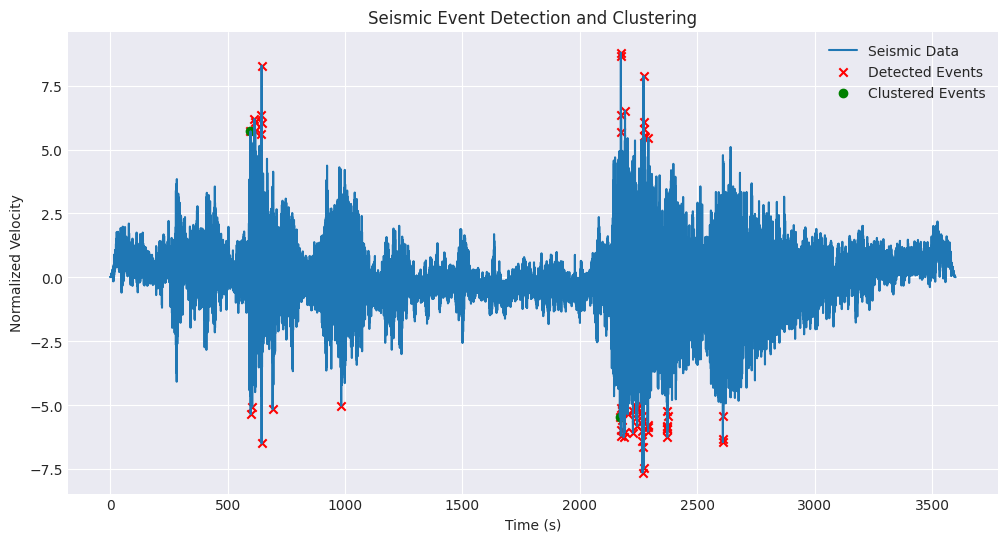

In [5]:
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed'
st = read(file_path)
tr = st[0]
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)
data_points = tr_data_norm.reshape(-1, 1)
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(data_points)
anomalies = iso_forest.predict(data_points)
anomalies_indices = np.where(anomalies == -1)[0]
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[anomalies_indices], tr_data_norm[anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection Using Isolation Forest')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

event_times = tr_times[anomalies_indices]
#print("Seismic events detected at times (s):", event_times)
clustered_points = [event_times[0]]  
proximity_threshold = 600
min_points_required = 5
for i in range(1, len(event_times)):
    nearby_points = np.sum((event_times >= event_times[i] - proximity_threshold) & (event_times <= event_times[i] + proximity_threshold))
    if nearby_points >= min_points_required and event_times[i] - clustered_points[-1] >= 600:
        clustered_points.append(event_times[i])
print("Clustered seismic events:", clustered_points)
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[anomalies_indices], tr_data_norm[anomalies_indices], color='red', label='Detected Events', marker='x')
plt.scatter(clustered_points, tr_data_norm[np.isin(tr_times, clustered_points)], color='green', label='Clustered Events', marker='o')
plt.title('Seismic Event Detection and Clustering')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()
#########################################
file_path = r'/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed'
st = read(file_path)
tr = st[0]
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)
data_points = tr_data_norm.reshape(-1, 1)
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(data_points)
anomalies = iso_forest.predict(data_points)
anomalies_indices = np.where(anomalies == -1)[0]
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[anomalies_indices], tr_data_norm[anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection Using Isolation Forest')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()

event_times = tr_times[anomalies_indices]
#print("Seismic events detected at times (s):", event_times)
clustered_points = [event_times[0]]  
proximity_threshold = 600
min_points_required = 5
for i in range(1, len(event_times)):
    nearby_points = np.sum((event_times >= event_times[i] - proximity_threshold) & (event_times <= event_times[i] + proximity_threshold))
    if nearby_points >= min_points_required and event_times[i] - clustered_points[-1] >= 600:
        clustered_points.append(event_times[i])
print("Clustered seismic events:", clustered_points)
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[anomalies_indices], tr_data_norm[anomalies_indices], color='red', label='Detected Events', marker='x')
plt.scatter(clustered_points, tr_data_norm[np.isin(tr_times, clustered_points)], color='green', label='Clustered Events', marker='o')
plt.title('Seismic Event Detection and Clustering')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.show()


For the two algorithms, we computed the execution time and memory usage after running the scripts on XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed file. 

STA\LTA: \
Running time: 0.17 seconds \
Memory used: 4.27 MB

Isolation Forest: \
Running time: 1.36 seconds \
Memory used: 7.21 MB

### Using Isolation Forest on Poisition Channels

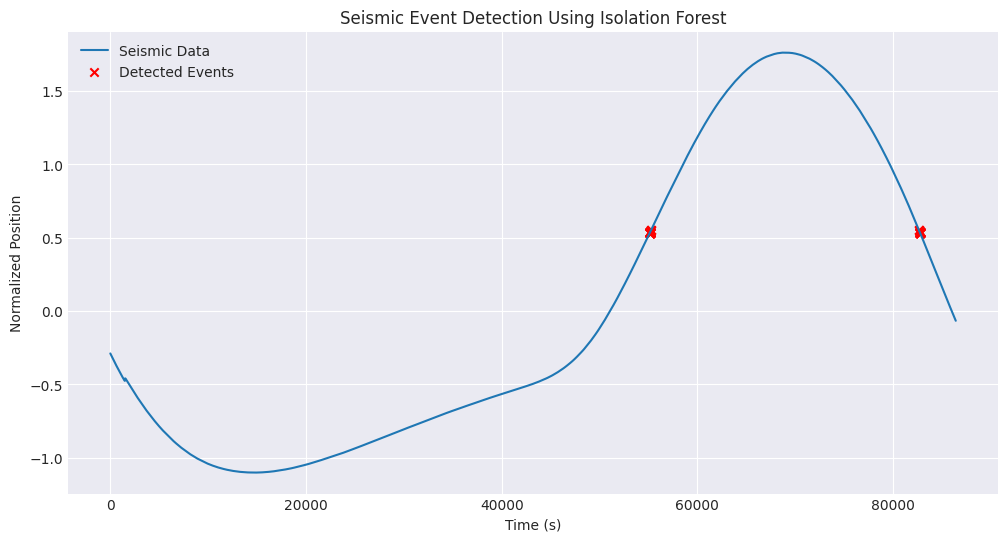

Clustered seismic events: [55117.63793562426, 82627.9563420873]


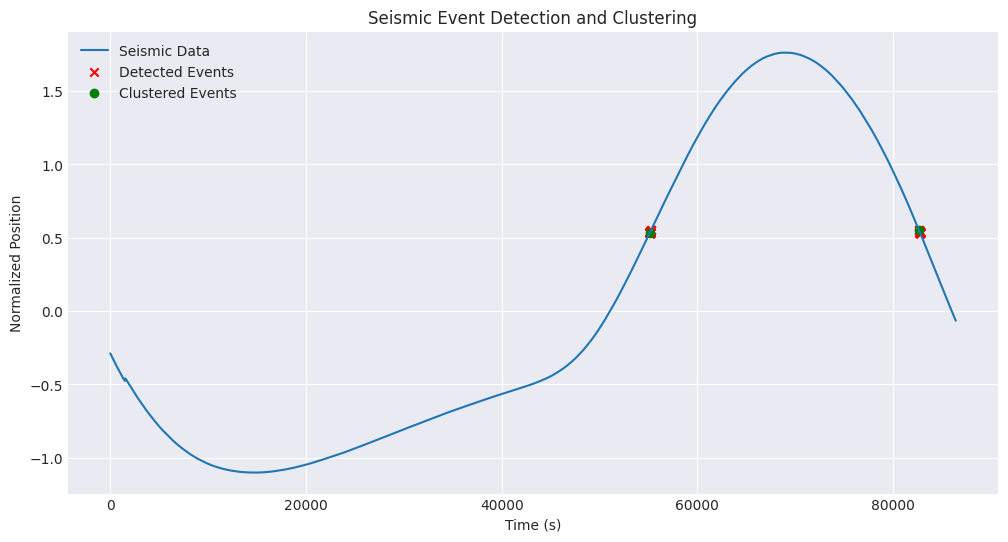

In [6]:
file_path = r"/kaggle/input/position-mseed-files/xb.elyse.05.lmu.2019.038.6.mseed"
st = read(file_path)
tr = st[0]
tr_data = tr.data
tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)
data_points = tr_data_norm.reshape(-1, 1)
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(data_points)
anomalies = iso_forest.predict(data_points)
anomalies_indices = np.where(anomalies == -1)[0]
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[anomalies_indices], tr_data_norm[anomalies_indices], color='red', label='Detected Events', marker='x')
plt.title('Seismic Event Detection Using Isolation Forest')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Position')
plt.legend()
plt.show()

event_times = tr_times[anomalies_indices]
#print("Seismic events detected at times (s):", event_times)
clustered_points = [event_times[0]]  
proximity_threshold = 600
min_points_required = 5
for i in range(1, len(event_times)):
    nearby_points = np.sum((event_times >= event_times[i] - proximity_threshold) & (event_times <= event_times[i] + proximity_threshold))
    if nearby_points >= min_points_required and event_times[i] - clustered_points[-1] >= 600:
        clustered_points.append(event_times[i])
print("Clustered seismic events:", clustered_points)
plt.figure(figsize=(12, 6))
plt.plot(tr_times, tr_data_norm, label='Seismic Data')
plt.scatter(tr_times[anomalies_indices], tr_data_norm[anomalies_indices], color='red', label='Detected Events', marker='x')
plt.scatter(clustered_points, tr_data_norm[np.isin(tr_times, clustered_points)], color='green', label='Clustered Events', marker='o')
plt.title('Seismic Event Detection and Clustering')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Position')
plt.legend()
plt.show()